# **1. Predict <u>churn probability</u> per user**

<details >
<summary><b>About :</b>(click to expand)</summary>


Predict <u>churn probability</u> per user at the last date in the dataset, using purchase history.

Run Kernel → Restart & Run All. `[Set FORCE_REBUILD=True to recompute artifacts.]`

**GitHub**:  https://github.com/nil-alami/Customer_Churn 

#### **Assumptions**:
- in preprocessing/Duplication: Exact Duplicated items are `systemic bias` not user behavior.
- Two approaches: a no ML heuristic + an unsupervised k-means clustering.

#### **Constraints**:
- no labels exist
- no sequences per fixed time window.

#### **Output**:
    one probability per user

</details>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from pathlib import Path
from IPython.display import display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import silhouette_score

<hr style="border:4px solid #999">

# **2. Load & inspect data**

In [11]:
df_raw = pd.read_csv("dataset.csv")
df_cleaned = df_raw.copy()

display(df_raw.head())
display(df_raw.describe())
df_raw.info()

unique_user_count = df_raw["UserId"].nunique()
print("\n unique_user_count : ",unique_user_count)

,UserId,Type,PurchasedAt,PurchasedAmount
0,9,1,3/9/2019,974460
1,17,1,3/12/2019,3248200
2,20,1,3/13/2019,974460
3,28,1,3/19/2019,974460
4,29,1,3/23/2019,974460


,UserId,Type,PurchasedAmount
count,278166.000000,278166.000000,2.781660e+05
mean,100482.220829,1.655044,6.179461e+06
std,52613.138455,1.239377,1.357164e+07
min,1.000000,1.000000,1.000000e+03
25%,53044.000000,1.000000,1.992000e+06
50%,98232.000000,1.000000,3.289875e+06
75%,147804.750000,1.000000,5.636834e+06
max,202320.000000,4.000000,9.572285e+08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278166 entries, 0 to 278165
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   UserId           278166 non-null  int64 
 1   Type             278166 non-null  int64 
 2   PurchasedAt      278166 non-null  object
 3   PurchasedAmount  278166 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 8.5+ MB

 unique_user_count :  60396


<hr style="border:4px solid #999">

# **3. Preprocessing**

**output**: A clean transactional dataset

### 3-1. Duplication
(exact row duplicates)

In [17]:
n_rows = len(df_raw)
n_users = df_raw['UserId'].nunique()

dup_mask = df_raw.duplicated()   # defaults to keep='first'
n_dupes = int(dup_mask.sum())
dup_pct = (n_dupes / n_rows) * 100

print(f"number of exact duplicates: {n_dupes}  # keep='first'")
print(f"percentage of duplication in dataset: {dup_pct:.2f}%")

dup_group_mask = df_raw.duplicated(keep=False)  # all
dup_rows = df_raw.loc[dup_group_mask] 

affected_users = dup_rows['UserId'].nunique()
pct_users_affected = (affected_users / n_users) * 100

print(f"\n Users affected by duplicates: {affected_users}")
print(f"\n percentage of Users affected: {pct_users_affected:.2f}% \n")

# Which users are worst affected?
print("users worst affected: \n",dup_rows['UserId'].value_counts().head(10))  

# Dedup
df_cleaned = df_raw.loc[~dup_mask].copy()  # (keeps first exact duplicate)

# sanity check
print("\n number of exact duplicates (after dedup):", 
      int(df_cleaned.duplicated().sum()))


number of exact duplicates: 5069  # keep='first'
percentage of duplication in dataset: 1.82%

 Users affected by duplicates: 2968

 percentage of Users affected: 4.91% 

users worst affected: 
 UserId
52007     73
65462     64
25915     62
65963     60
26162     52
51965     36
92993     34
1663      32
176261    31
25000     30
Name: count, dtype: int64

 number of exact duplicates (after dedup): 0


---
<details >
<summary><b>Dedup report :</b>(click to expand)</summary>
    
Duplication at Row-level view => Low\
Duication at t User-level view => (≈ 1 in 20 users) not small.\
Duplicates are not evenly distributed.\
A small set of users are heavily duplicated. In clustring, these users will:
- Look hyper-active
- Look ultra-loyal
- Dominate frequency-based features
- Skew clustering centroids

Exact Duplicated rows are considered **systemic bias** not user behavior. So,
Dropping it prevents:
- inflated Frequency features
- artificially small Recency features
    
</details>

---
### 3-2. Feature conversions and value checks 

<details > <summary><b>About :</b>(click to expand)</summary>
</br>
    
**"PurchasedAt" feature** : needs to be Converted to `pandas datetime`. (for feature engineering such as recency, purchase gaps and ...) \
`object(str) → datetime64[ns]`


**"Type" feature** : It's categorical.
</details>



In [20]:
df = df_cleaned

# "PurchasedAt" 
#-----------------
df['PurchasedAt'] = pd.to_datetime(df['PurchasedAt'], errors='coerce')
df.info()
min_date = df['PurchasedAt'].min()
max_date = df['PurchasedAt'].max()

print("\n min date: {},\n max date : {}\n".format(min_date,max_date))

# "PurchasedAmount" 
#--------------------
df = df[df['PurchasedAmount'] > 0]   # zero|negative amounts are invalid

# "Type" 
#--------------------
invalid = df.loc[~df['Type'].isin({1, 4}), 'Type'] # checking only allowed-values
print(f"\n Invalid Type rows: {len(invalid)}")


 min date: 2019-03-09 00:00:00,
 max date : 2025-12-06 00:00:00

<class 'pandas.core.frame.DataFrame'>
Index: 273097 entries, 0 to 278165
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   UserId           273097 non-null  int64         
 1   Type             273097 non-null  int64         
 2   PurchasedAt      273097 non-null  datetime64[ns]
 3   PurchasedAmount  273097 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 10.4 MB

 Invalid Type rows: 0


---
### 3-3. Sorting

<details > <summary><b>About :</b>(click to expand)</summary>
<br>
    
necessary for k-means + If the data isn’t sorted by time per user, might get:
- negative gaps
- wrong average gap
- wrong “last purchase” logic    
</details>

In [21]:
df = df.sort_values(['UserId', 'PurchasedAt']).reset_index(drop=True)
df.head()

,UserId,Type,PurchasedAt,PurchasedAmount
0,1,1,2020-01-07,56844
1,1,1,2020-01-07,11369
2,1,4,2020-03-11,1000
3,1,1,2020-09-16,19421
4,1,1,2021-01-09,11363


<hr style="border:4px solid #999">

# **4. Feature engineering**

**output**: A user-level dataset 

<details > <summary><b>About :</b>(click to expand)</summary>
<br>
    
The raw dataset is <u>transactional</u>, with one row per purchase event. Since churn is defined at the <u>customer level</u>, the data was aggregated to a **user-level representation**.\
Each user is represented by a single row of `behavioral features` derived from their purchase history, such as recency, frequency, and monetary value `(RFM-style features)`. 

- **Recency**: How long since the user last purchased?
- **Frequency**: How often did the user purchase?
- **Monetary**: How much value did the user generate?
-   
</details>

In [22]:
max_date = df['PurchasedAt'].max()  # global reference time  (features like recency will use this)

# User_level df: [user_features]
# -------------------------------------------

# adding core RFM features to df
user_features = (df.groupby('UserId').agg(
        first_purchase_date=('PurchasedAt', 'min'),  
        last_purchase_date=('PurchasedAt', 'max'),  

        total_purchases=('PurchasedAt', 'count'),  # frequency

        total_spend=('PurchasedAmount', 'sum'),  # Monetary
        avg_spend=('PurchasedAmount', 'mean')   
    ).reset_index())

# recency
user_features['recency_days'] = (max_date - user_features['last_purchase_date']).dt.days

# gap features
df['gap_days'] = (df.groupby('UserId')['PurchasedAt'].diff().dt.days)  # Days between consecutive purchases (NaN for first purchases)
gap_features = (df.groupby('UserId')['gap_days']
      .agg(
          avg_gap_days='mean', # average time between purchases 
          max_gap_days='max'  # max gap between purchases 
      ).reset_index())

user_features = user_features.merge(gap_features, on='UserId', how='left') # attaching to user-level DS

# recency_gap_ratio (Recency anomaly), How long has the user been inactive relative to their normal buying rhythm?
user_features['recency_to_avg_gap'] = (user_features['recency_days'] / user_features['avg_gap_days'])


# number of unique purchase dates
num_active_days = (df.groupby('UserId')['PurchasedAt']
      .nunique()
      .rename('num_active_days')
      .reset_index())  
user_features = user_features.merge(num_active_days, on='UserId', how='left')


# "Type(product)" behavioral features
type_features = df.groupby('UserId').agg(
    num_prod_A=('Type', lambda x: (x == 1).sum()),
    num_prod_B=('Type', lambda x: (x == 4).sum())
)
user_features = user_features.merge(type_features, on='UserId', how='left')

user_features['share_A'] = user_features['num_prod_A'] / user_features['total_purchases']  # Convert to proportions
user_features['share_B'] = user_features['num_prod_B'] / user_features['total_purchases']
user_features = user_features.drop(columns=['num_prod_A','num_prod_B'])


# Monetary behavioral features (from PurchasedAmount)
user_features['log_total_spend'] = np.log1p(user_features['total_spend'])  # log Transform them (was heavily right-skewed) (log1p: no -inf)
user_features['log_avg_spend'] = np.log1p(user_features['avg_spend'])
user_features = user_features.drop(columns=['total_spend','avg_spend'])


# Tenure & activity
"""
customer_age_days , active_ratio: distinguish new inactive users from long-term inactive users and 
                                  to capture engagement consistency over time.
"""
user_features['customer_age_days'] = (max_date - user_features['first_purchase_date']).dt.days
customer_age_days_nonzero = user_features['customer_age_days'].replace(0, np.nan)

# active_ratio 
user_features['active_ratio'] = user_features['num_active_days'] / customer_age_days_nonzero  # days active / days since first purchase
user_features['active_ratio'] = user_features['active_ratio'].fillna(0.0)

user_features.head()

,UserId,first_purchase_date,last_purchase_date,total_purchases,recency_days,avg_gap_days,max_gap_days,recency_to_avg_gap,num_active_days,share_A,share_B,log_total_spend,log_avg_spend,customer_age_days,active_ratio
0,1,2020-01-07,2024-12-29,24,342,79.043478,626.0,4.326733,21,0.875000,0.125000,13.212506,10.034494,2160,0.009722
1,2,2019-12-24,2020-01-14,3,2153,10.500000,21.0,205.047619,2,0.666667,0.333333,14.544730,13.446118,2174,0.000920
2,9,2019-03-09,2019-03-09,1,2464,NaN,NaN,NaN,1,1.000000,0.000000,13.789640,13.789640,2464,0.000406
3,14,2019-08-04,2022-11-14,5,1118,299.500000,851.0,3.732888,5,0.600000,0.400000,15.435300,13.825863,2316,0.002159
4,17,2019-03-12,2023-06-11,4,909,517.333333,824.0,1.757088,4,0.250000,0.750000,15.859092,14.472798,2461,0.001625


<details style="background:#f0f8ff; padding:10px; border-radius:8px; border:1px solid #d0d7de;"> 
    <summary><b>Features :</b>(click to expand)</summary>
<br>    

| Feature name                             | Definition / Formula                      | What it captures        | Interpretation                            |
| ---------------------------------------- | ----------------------------------------- | ----------------------- | ----------------------------------------- |
| **UserId**                               | Unique identifier of the user             | Identity                | -                                         |
| **total_purchases**                      | Number of purchase records for the user   | **Frequency (F)**       | Higher → more engaged customer            |
| **total_spend** *(dropped)*              | Sum of PurchasedAmount                    | Monetary value (raw)    | Dropped due to heavy skew                 |
| **avg_spend** *(dropped)*                | total_spend / total_purchases             | Avg value per purchase  | Replaced by log version                   |
| **log_total_spend**                      | log(total_spend + 1)                      | **Monetary (M)**        | Higher → higher customer value            |
| **log_avg_spend** *(optional / dropped)* | log(avg_spend + 1)                        | Avg monetary intensity  | Optional, correlated with log_total_spend |
| **recency_days**                         | (last_date − last_purchase_date) in days  | **Recency (R)**         | Lower → more recently active              |
| **avg_gap_days**                         | Mean days between consecutive purchases   | Purchase rhythm         | Lower → more frequent buying              |
| **max_gap_days** *(dropped)*             | Max gap between purchases                 | Extreme inactivity      | Dropped (too noisy)                       |
| **recency_to_avg_gap**                   | recency_days / avg_gap_days               | **Inactivity vs habit** | ≈1 normal, >1 overdue, <1 active          |
| **num_active_days**                      | Number of unique days with purchases      | Activity spread         | Higher → sustained activity               |
| **customer_age_days**                    | (last_date − first_purchase_date)         | Tenure                  | New vs long-term customers                |
| **active_ratio**                         | num_active_days / customer_age_days       |   **Consistency**       | Higher → habit-forming user               |
| **num_prod_A** *(dropped)*               | Count of product A purchases              | Raw product usage       | Dropped after share calculation           |
| **share_A**                              | num_prod_A / total_purchases              | Product mix             | User preference signal                    |



| Feature                       |  |
| ----------------------------- | ----------- |
| **UserId**                   |
| **total_purchases**           | **تعداد کل خریدهای کاربر** (نشان‌دهنده‌ی میزان تعامل / وفاداری)                                                                                       |
| **total_spend** *(حذف‌شده)*   | مجموع کل مبلغی که کاربر خرج کرده                                                                                                           |
| **avg_spend** *(حذف‌شده)*     | میانگین مبلغ هر خرید                                                                                                                      |
| **log_total_spend**           | لگاریتم مجموع مبلغ خkew) → **ارزش مالی کاربر**                                                                                 |
| **log_avg_spend** *(اختیاری)* | لگاریتم میانگین مبلغ هر خرید                                                                                                                  |
| **recency_days**              | **تعداد روزهایی که از آخرین خرید کاربر گذشته** (هر, بیشتر → ریسک ریزش بالاتر)                                                                       |
| **avg_gap_days**              | **میانگین فاصله‌ی زمانی بین خریدهای کاربر**                                                                                                    |
| **max_gap_days** *(حذف‌شده)*  | بیشترین فاصله‌ی زمانی بین دو خرید                                                                                                            |
| **recency_to_avg_gap**        | **نسبت زمان عدم‌فعالیت فعلی به الگوی معمول خرید کاربر**  \n`recency_days / avg_gap_da:s`  \n≈ ۱ → رفتار ع:دی  \n> ۱ → دیرتر از عادت (ریسک ری:ش)  \n< ۱ → هنوز فعال |
| **num_active_days**           | تعداد روزهای منحصربه‌فردی که کاربر خرید انجام داده                                                                                                |
| **customer_age_days**         | **مدت‌زمانی که از اولین خرید کاربر گذشته** (سن مشتری)                                                                                           |
| **active_ratio**              | **نسبت روزهای فعال به کل عمر مشتری**  \n`num_active_days / customer_age_days`  \nنشان‌دهنده‌ی ثبات رفتار                                           |
| **num_prod_A** *(حذف‌شده)*    | تعداد خریدهای محصول نوع A                                                                                                                 |
| **share_A**                   | سهم خرید محصول A از                                                                                                       |


</details>                                      |


---
### 4-1. Feature engineering Diagnostics & Analysis

<details > <summary><b>About :</b>(click to expand)</summary>
<br>

Doing some visualizations to check for redundancy, skew and ... 
- Correlation heatmap
  
**result**:
some feature redundancy was identified and was handled by removing redundant ones.\
The remaining features exhibit complementary information suitable for distance-based clustering.

</details>


#### 4-1-1. Correlation heatmap
to inspect <u>relationships</u> and <u>redundancy</u> among core behavioral features prior to clustering.

<details style="background:#f0f8ff; padding:10px; border-radius:8px; border:1px solid #d0d7de;"> 
    <summary><b>report :</b>(click to expand)</summary>
<br>
    
the heatmap shows feature set is mostly well-chosen

**Frequency relationships**
- `total_purchases ↔ num_active_days = 1.00` : perfectly correlated, encoding the same information. num_active_days **Dropped**.

**Recency relationships**
- `recency_days vs log_total_spend → -0.60`
- `recency_days vs customer_age_days → +0.60`
High-value customers are usually more active and Low spenders are more likely to go inactive (expected pattern in churn data)

**Gap-based features**
- `avg_gap_days ↔ max_gap_days = 0.80` : Both describe purchase spacing. avg_gap_days reflects habit, so, max_gap_days **Dropped**.
- `avg_gap_days vs recency_days → +0.16` (mild)
- `avg_gap_days vs share_A → -0.56` (strong)

**active_ratio** 
low correlation with most features `adds information`, can help separate edge cases (new vs old inactive users)

**Monetary features**
- `log_total_spend ↔ log_avg_spend = 0.68` : log_total_spend(lifetime value) with total_purchases (frequency) implicitly encode average spend. so, log_avg_spend adds little information **Dropped**.\

</details>

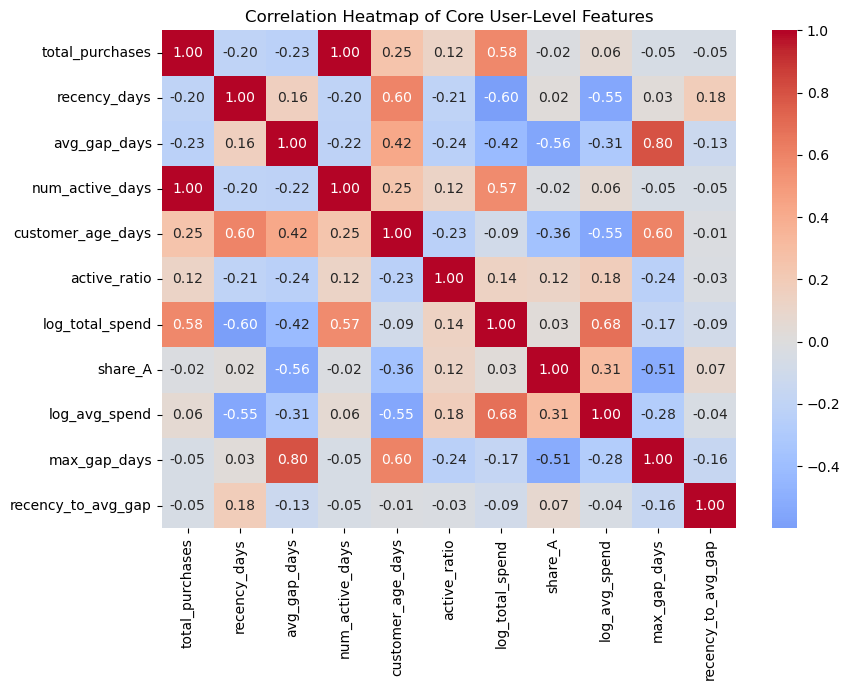

In [24]:
corr_features = [
    'total_purchases',
    'recency_days',
    'avg_gap_days',
    'num_active_days',
    'customer_age_days',
    'active_ratio',
    'log_total_spend',
    'share_A',
    'log_avg_spend',
    'max_gap_days',
    'recency_to_avg_gap'
]

# Correlation
corr = user_features[corr_features].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap of Core User-Level Features")
plt.tight_layout()
plt.show()

---
### 4-2. Removing redundant features

In [25]:
#remove redundant features 
user_features = user_features.drop(columns=['num_active_days','share_B','log_avg_spend', 'max_gap_days' ],errors='ignore')  
print(user_features.columns)

Index(['UserId', 'first_purchase_date', 'last_purchase_date',
       'total_purchases', 'recency_days', 'avg_gap_days', 'recency_to_avg_gap',
       'share_A', 'log_total_spend', 'customer_age_days', 'active_ratio'],
      dtype='object')


---
### 4-3. Sanity checks

#### 4-5-1. Missing values

<details > <summary><b>About :</b>(click to expand)</summary>
<br>
    
Checking for No NaNs before K-Means. \
These have null values (users with 1 purchase → no gaps: NaN):
- avg_gap_days  
- recency_to_avg_gap
  
NaN → filled with `recency_days` [for first buyers the only gap is `the time since that purchase`]    
</details>


In [26]:
user_features['avg_gap_days'] = user_features['avg_gap_days'].fillna(user_features['recency_days'])

user_features['recency_to_avg_gap'] = user_features['recency_to_avg_gap'].replace(
    [np.inf, -np.inf], np.nan).fillna(1.0)  # Neutral ratio

# No NaNs before K-Means
assert user_features.isna().sum().sum() == 0

---
### 4-4. Cache/store

cache/store the user-level aggregated dataset:
- `artifacts/user_features.parquet`
- `artifacts/user_features.csv`

In [103]:
# cache/store the user-level aggregated dataset

ART = Path("artifacts")
ART.mkdir(exist_ok=True)

FORCE_REBUILD = False
USER_FEATS_PATH = ART / "user_features.parquet"
USER_FEATS_CSV = ART / "user_features.csv"

# If force rebuild + delete cached files 
if FORCE_REBUILD and USER_FEATS_PATH.exists():
    USER_FEATS_PATH.unlink(missing_ok=True)
    USER_FEATS_CSV.unlink(missing_ok=True)

# Ensure the artifact exists
if not USER_FEATS_PATH.exists():
    user_features.to_parquet(USER_FEATS_PATH, index=False)
    user_features.to_csv(USER_FEATS_CSV, index=False)

user_features = pd.read_parquet(USER_FEATS_PATH)

<hr style="border:4px solid #999">

# **5. Model Training** 

**output**: ...

### 5-1. Scaling

In [104]:
# using StandardScaler
scaler = StandardScaler()

user_ids = user_features['UserId'].values  
model_features = [
    'total_purchases',
    'recency_days',
    'avg_gap_days',
    'recency_to_avg_gap',
    # 'share_A',   Decided it's a preference and not useful in churn clustring
    'log_total_spend',
    'active_ratio',
    'customer_age_days',
]  # no id or date feature

X = user_features[model_features].copy()
X = pd.DataFrame(
    scaler.fit_transform(X),
    columns=X.columns,
    index=X.index)

display(X.head())
X.info()
X.isna().sum()

,total_purchases,recency_days,avg_gap_days,recency_to_avg_gap,log_total_spend,active_ratio,customer_age_days
0,2.564418,-0.129472,-0.571592,-0.045239,-2.333607,-0.045081,2.336881
1,-0.200350,3.787367,-0.740862,3.789585,-1.278387,-0.298813,2.360751
2,-0.463661,4.460000,5.318150,-0.108797,-1.876474,-0.313633,2.855209
3,0.062961,1.548864,-0.027166,-0.056585,-0.572990,-0.263100,2.602865
4,-0.068694,1.096838,0.510782,-0.094333,-0.237315,-0.278479,2.850094


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60396 entries, 0 to 60395
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   total_purchases     60396 non-null  float64
 1   recency_days        60396 non-null  float64
 2   avg_gap_days        60396 non-null  float64
 3   recency_to_avg_gap  60396 non-null  float64
 4   log_total_spend     60396 non-null  float64
 5   active_ratio        60396 non-null  float64
 6   customer_age_days   60396 non-null  float64
dtypes: float64(7)
memory usage: 3.2 MB


total_purchases       0
recency_days          0
avg_gap_days          0
recency_to_avg_gap    0
log_total_spend       0
active_ratio          0
customer_age_days     0
dtype: int64

---

### 5-2. Approach 1: **Heuristic churn model (no ML)**


<details > <summary><b>About :</b>(click to expand)</summary>
<br>

based on RFM features, we can say a user is at risk of churn if the time since their last purchase is large relative to their typical purchase frequency and historical value\
features:
- recency_days
- total_purchases
- customer_age_days
- log_total_spend

Assumptions: 
- High recency → higher risk
- Low frequency → higher risk
- Low monetary value → higher risk

churn_score = w1 * recency_norm + w2 * (1 - freq_norm) + w3 * (1 - monetary_norm) 

Since no explicit churn labels are available, a heuristic approach was implemented to estimate churn risk using customer behavioral patterns. The core intuition is that a customer is at risk of churn if the time since their last purchase significantly exceeds their typical purchase frequency, especially when combined with low historical engagement and monetary value.

Recency, frequency, and monetary features were normalized and combined into a weighted churn score, where recency received the highest weight due to its strong relationship with inactivity and churn. The resulting score was scaled to the [0,1] range and interpreted as a churn probability.
</details>


In [105]:
df_h = user_features.copy()  # new dataFrame for heuristic approach

# 1- Compute each user’s typical purchase frequency (how often this user usually buys.)
df_h['typical_gap_days'] = (df_h['customer_age_days'] / df_h['total_purchases'])
df_h['typical_gap_days'] = df_h['typical_gap_days'].replace([np.inf, -np.inf], np.nan).fillna(df_h['recency_days']) # handle division edge cases

# 2- Compare recency against typical behavior
# if recency_days ≫ typical_gap_days then the user is late relative to their normal rhythm → churn risk.
df_h['recency_to_typical_gap'] = (df_h['recency_days'] / df_h['typical_gap_days'])
df_h['recency_to_typical_gap'] = df_h['recency_to_typical_gap'].replace([np.inf, -np.inf], np.nan).fillna(1.0)  # neutral ratio for edge cases

# 3- Normalize features (min-max)
def min_max_norm(x):
    return (x - x.min()) / (x.max() - x.min())

df_h['recency_norm'] = min_max_norm(df_h['recency_days'])
df_h['freq_norm']    = min_max_norm(df_h['total_purchases'])
df_h['monetary_norm']= min_max_norm(df_h['log_total_spend'])

# 4- make heuristic churn score
w1 = 0.45   #(recency dominates churn)
w2 = 0.30   #(engagement matters)
w3 = 0.25   #(value matters, but less)

df_h['churn_score_heuristic'] = (
    w1 * df_h['recency_norm']
  + w2 * (1 - df_h['freq_norm'])
  + w3 * (1 - df_h['monetary_norm']))

# 5- Convert score to probability [0,1]
df_h['prob_churn_heuristic'] = df_h['churn_score_heuristic'].clip(0, 1)  # already used min-max

# Attacch to df
user_features = user_features.merge(df_h[['prob_churn_heuristic','UserId']], on='UserId', how='left')
user_features.to_csv("artifacts/heuristic_churn_scores.csv", index=False)


# top-risk users
df_h.sort_values('prob_churn_heuristic', ascending=False).head(10)[[
    'recency_days',
    'total_purchases',
    'log_total_spend',
    'prob_churn_heuristic']]  # very high recency, low purchases, low spend


,recency_days,total_purchases,log_total_spend,prob_churn_heuristic
2,2464,1,13.78964,0.914136
32,2397,1,13.78964,0.901899
38,2396,1,13.78964,0.901717
46,2391,1,13.78964,0.900804
54,2385,1,13.78964,0.899708
53,2382,1,13.78964,0.899160
62,2373,1,13.78964,0.897516
67,2373,1,13.78964,0.897516
48,2373,1,13.78964,0.897516
64,2372,1,13.78964,0.897334


---

### 5-3. Approach 2: **K-Means churn model (unsupervised ML)**


<details > <summary><b>About :</b>(click to expand)</summary>
<br>
    
Cluster users into behavioral groups and interpret some clusters as “high churn risk.” (“hibernating”, “at risk”, etc.)

- based on domain knowledge, for churn the number of clusters typically falls in: `K∈[3, 7]`
- in regard to that, we try to choose K with **elbow , silhouette** methods

choosing K → fitting K-Means → interpret → derive probabilities from distances → then assign churn risk
</details>

#### 5-3-1. Elbow method

measuring Inertia (within-cluster sum of squares)

<details style="background:#f0f8ff; padding:10px; border-radius:8px; border:1px solid #d0d7de;"> 
    <summary><b>report :</b>(click to expand)</summary>
<br>

k=[5,6] is where improvement slows down, a visible “bend”.
from this plot:
- Candidate K ∈ {5, 6}
- possible segments: (Loyal, Active, At-risk, Likely churned, New users, Dormant long-term users)
- Two clusters may be behaviorally similar (overlap) which may make mapping to churn probabilities harder    
</details>

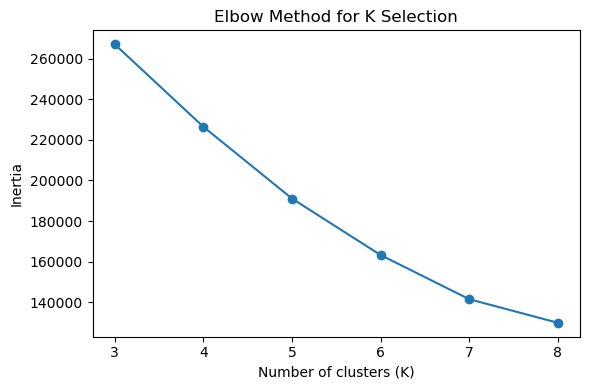

In [58]:
# Elbow method
inertias = []
K_range = range(3,9)

for k in K_range:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    km.fit(X)
    inertias.append(km.inertia_)

# plotting inertia
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for K Selection")
plt.tight_layout()
plt.show()

#### 5-3-2. Silhouette score
Measures how well clusters are separated.

<details style="background:#f0f8ff; padding:10px; border-radius:8px; border:1px solid #d0d7de;"> 
    <summary><b>report :</b>(click to expand)</summary>
<br>

based on the plot the k=5 has **higher silhouette score** and possibly gives **better separation**.    
</details>



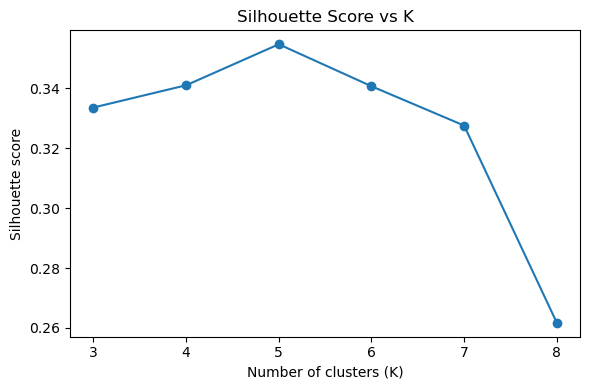

In [59]:
# Silhouette score
sil_scores = []

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

# plotting
plt.figure(figsize=(6, 4))
plt.plot(K_range, sil_scores, marker='o')
plt.xlabel("Number of clusters (K)")
plt.ylabel("Silhouette score")
plt.title("Silhouette Score vs K")
plt.tight_layout()
plt.show()

#### 5-3-3. Fitting final k-means

assigning a cluster to each user

In [106]:
# final k-means
k_final = 5

kmeans = KMeans(
    n_clusters=k_final,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans.fit_predict(X)

# Attach clusters to users [one user → one cluster, no interpretation yet]
user_features['cluster'] = cluster_labels  
user_features.head()

,UserId,first_purchase_date,last_purchase_date,total_purchases,recency_days,avg_gap_days,recency_to_avg_gap,share_A,log_total_spend,customer_age_days,active_ratio,prob_churn_heuristic,cluster
0,1,2020-01-07,2024-12-29,24,342,79.043478,4.326733,0.875000,13.212506,2160,0.009722,0.514569,2
1,2,2019-12-24,2020-01-14,3,2153,10.500000,205.047619,0.666667,14.544730,2174,0.000920,0.841192,1
2,9,2019-03-09,2019-03-09,1,2464,2464.000000,1.000000,1.000000,13.789640,2464,0.000406,0.914136,1
3,14,2019-08-04,2022-11-14,5,1118,299.500000,3.732888,0.600000,15.435300,2316,0.002159,0.633484,1
4,17,2019-03-12,2023-06-11,4,909,517.333333,1.757088,0.250000,15.859092,2461,0.001625,0.588362,1


#### 5-3-4. Cluster Size distribution

Bar Chart reflects natural behavioral imbalance, since in customer churn analysis most customers behave “normally” and only a small fraction are extreme churners or unusual edge cases.   
 

<details style="background:#f0f8ff; padding:10px; border-radius:8px; border:1px solid #d0d7de;"> 
    <summary><b>report :</b>(click to expand)</summary>
<br>
    
Cluster sizes align very well with behavioral profiles. (following sections in cluster_profiles)\
The large cluster represent average, stable users.\
Small clusters represent highly inactive users, new users and rare behavioral patterns.
</details>

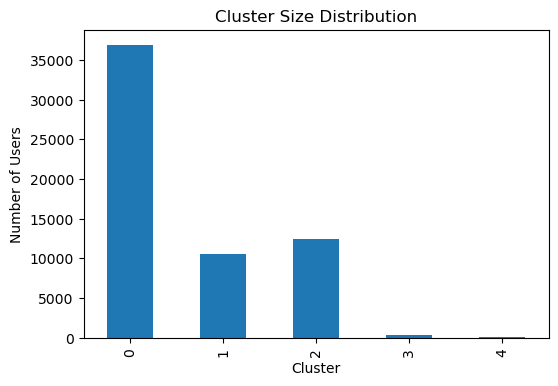

In [91]:
cluster_counts = user_features['cluster'].value_counts().sort_index()

plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.title('Cluster Size Distribution')
plt.show()

#### 5-3-5. Map clusters to probabilities

<details > <summary><b>workflow :</b>(click to expand)</summary>
<br>

**1) making cluster profiles**
cluster profiles are mean feature values per cluster, made for Interpreting clusters

**2) measuring churn Risk direction**:
- recency_days: higher => `worse` churn ↑
- recency_to_avg_gap: higher => `worse` churn ↑
- avg_gap_days: higher => `worse` churn ↑
- total_purchases: higher => `better` (higher total_purchases => lower churn risk) churn ↓
- log_total_spend: higher => `better`  churn ↓
- active_ratio: higher => `better` churn ↓

**3)** making **all ranks consistent** so that:
- Rank 1 = Best Performance (Lowest churn Risk)
- Highest Rank = Worst Performance (Highest churn Risk)

**4) calculate cluster risk score** (weighted sum of ranks)
- weights are reasonable for churn and follow domain logic : `Recency > Gap signals > F/M > Active`

**5) mapping risk scores to probabilities**
Because churn labels are unavailable, probabilities are not calibrated to true churn rates. instead we compute a monotonic probability-like mapping from cluster risk scores, preserving relative risk ordering.    
</details>    

In [107]:
# cluster profiles (mean feature values per cluster)
cluster_profiles = (
    user_features   # on unscaled features
    .groupby('cluster')[model_features]
    .mean())

cluster_profiles = cluster_profiles.reset_index()

# store
cluster_profiles.to_csv("artifacts/cluster_profiles.csv", index=False)



# relative ranking across clusters   (define all ranks as: 1=> best, K=> worst)
# ==============================================================================
cp = cluster_profiles.copy()

# their low is best
cp['rank_recency'] = cp['recency_days'].rank(method='dense', ascending=True)  # (ascending=True : higher rank to higher values)
cp['rank_r2gap'] = cp['recency_to_avg_gap'].rank(method='dense', ascending=True)
cp['rank_gap'] = cp['avg_gap_days'].rank(method='dense', ascending=True)

# their high is best
cp['rank_freq'] = cp['total_purchases'].rank(method='dense', ascending=False)  # (ascending=False : higher rank to lower values)
cp['rank_money'] = cp['log_total_spend'].rank(method='dense', ascending=False)  
cp['rank_active']  = cp['active_ratio'].rank(method='dense', ascending=False)     

# cluster risk score (weighted sum of ranks)
cp['risk_score'] = (
    2.0 * cp['rank_recency'] +
    1.5 * cp['rank_r2gap'] +
    1.0 * cp['rank_gap'] +
    1.0 * cp['rank_freq'] +
    1.0 * cp['rank_money'] +
    0.5 * cp['rank_active']
)

# rank to fixed probability levels
cp['risk_rank'] = cp['risk_score'].rank(method='dense', ascending=True)  # 1=lowest risk

rank_to_prob = {
    1: 0.05,  # 1st lowest-risk cluster, assign it a 5% churn probability
    2: 0.20,
    3: 0.50,
    4: 0.75,
    5: 0.90,  # the 5th (highest-risk) cluster, assign it a 90% churn probability.
}
cp['prob_churn_cluster'] = cp['risk_rank'].map(rank_to_prob)
cluster_churn_prob = cp['prob_churn_cluster'].to_dict()

# assign user-level probabilities
user_features['churn_prob_kmeans'] = user_features['cluster'].map(cluster_churn_prob)

(user_features[['UserId', 'churn_prob_kmeans']]).to_csv("churn_scores.csv", index=False)
user_features['churn_prob_kmeans'].describe()

count    60396.000000
mean         0.505822
std          0.218592
min          0.050000
25%          0.500000
50%          0.500000
75%          0.500000
max          0.900000
Name: churn_prob_kmeans, dtype: float64

#### 5-3-6. Analysis and Sanity checks

,UserId,first_purchase_date,last_purchase_date,total_purchases,recency_days,avg_gap_days,recency_to_avg_gap,share_A,log_total_spend,customer_age_days,active_ratio,prob_churn_heuristic,cluster,churn_prob_kmeans,prob_churn_combined
2,9,2019-03-09,2019-03-09,1,2464,2464.0,1.0,1.0,13.789640,2464,0.000406,0.914136,1,0.90,0.905654
23,41,2019-04-29,2019-05-01,2,2411,2.0,1205.5,1.0,14.482786,2413,0.000829,0.890466,4,0.75,0.806186
32,52,2019-05-15,2019-05-15,1,2397,2397.0,1.0,1.0,13.789640,2397,0.000417,0.901899,1,0.90,0.900760
38,60,2019-05-16,2019-05-16,1,2396,2396.0,1.0,1.0,13.789640,2396,0.000417,0.901717,1,0.90,0.900687
46,71,2019-05-21,2019-05-21,1,2391,2391.0,1.0,1.0,13.789640,2391,0.000418,0.900804,1,0.90,0.900321


,UserId,first_purchase_date,last_purchase_date,total_purchases,recency_days,avg_gap_days,recency_to_avg_gap,share_A,log_total_spend,customer_age_days,active_ratio,prob_churn_heuristic,cluster,churn_prob_kmeans,prob_churn_combined
60395,202320,2025-12-06,2025-12-06,1,0,0.000000,1.0,1.000000,16.210500,0,0.000000,0.418742,0,0.5,0.467497
28594,129666,2023-10-25,2025-12-06,18,0,45.470588,0.0,0.888889,17.973662,773,0.020699,0.368794,2,0.2,0.267517
5915,37484,2021-02-28,2025-12-06,28,0,64.518519,0.0,0.785714,18.133265,1742,0.012055,0.355867,2,0.2,0.262347
54660,191355,2025-08-05,2025-12-06,13,0,10.250000,0.0,1.000000,18.063643,123,0.105691,0.372073,2,0.2,0.268829
54578,191193,2025-07-20,2025-12-06,2,0,139.000000,0.0,1.000000,16.616150,139,0.014388,0.410142,0,0.5,0.464057


,UserId,recency_days,avg_gap_days,recency_to_avg_gap,churn_prob_kmeans
15024,90297,1286,0.5,2572.0,0.75
2804,13650,1276,0.5,2552.0,0.75
10479,53629,1146,0.5,2292.0,0.75
23445,101981,991,0.5,1982.0,0.75
3420,24452,1964,1.0,1964.0,0.75
3935,25100,1952,1.0,1952.0,0.75
4218,25460,1917,1.0,1917.0,0.75
1551,2019,1874,1.0,1874.0,0.75
24494,113498,919,0.5,1838.0,0.75
6842,48632,1748,1.0,1748.0,0.75


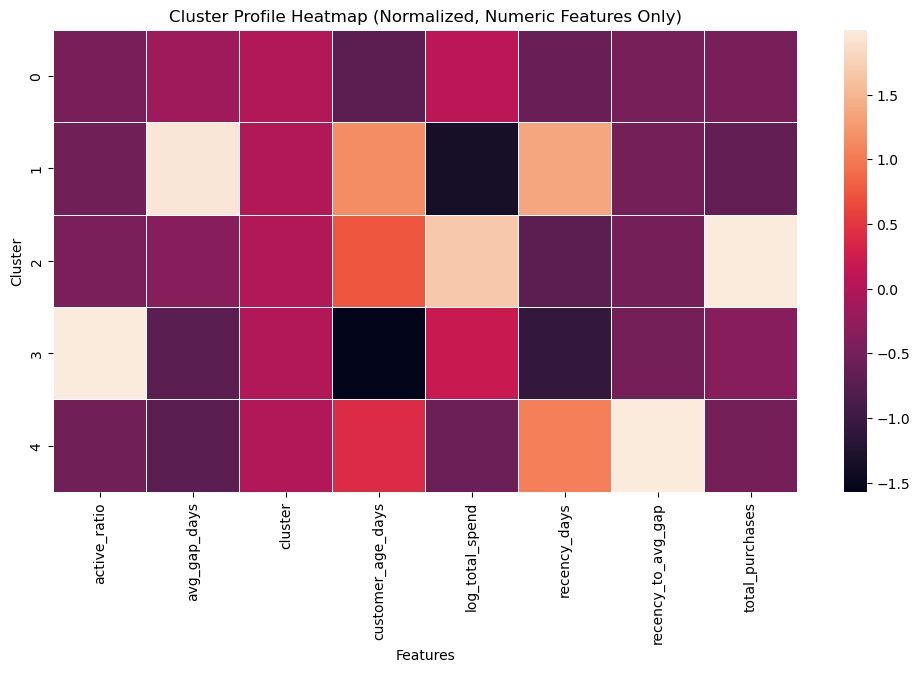

In [121]:
# Manually inspecting a few users
display(user_features.sort_values('recency_days', ascending=False).head())  # should have high churn probability
display(user_features.sort_values('recency_days').head())  # should have low churn probability

# Users whose last purchase was far in the past relative to their usual behavior
display(user_features.sort_values('recency_to_avg_gap', ascending=False)[
    ['UserId', 'recency_days', 'avg_gap_days', 'recency_to_avg_gap', 'churn_prob_kmeans']
].head(20))  # should have high churn probability, smaller avg_gap_days and ...


# plot Cluster Profile Heatmap 
# -------------------------------------------------------
cp_no_cluster = cluster_profiles.drop(columns=['cluster'])

# Normalize per feature for readability (z-score across clusters)
cluster_profiles_norm = (cp_no_cluster - cp_no_cluster.mean()) / cluster_profiles.std(ddof=0)

cluster_profiles_norm = cluster_profiles_norm.replace([np.inf, -np.inf], np.nan).fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(cluster_profiles_norm, linewidths=0.5)
plt.title('Cluster Profile Heatmap (Normalized, Numeric Features Only)')
plt.xlabel('Features')
plt.ylabel('Cluster')
plt.show()


<details style="background:#f0f8ff; padding:10px; border-radius:8px; border:1px solid #d0d7de;"> 
    <summary><b>report :</b>(click to expand)</summary>
<br>
    
from inspecting cluster means (cluster_profiles):

| Cluster | Behavior (summary)                                                                                | Interpretation                    |
| ------- | ------------------------------------------------------------------------------------------------- | --------------------------------- |
| **0**   | Low–moderate purchase frequency, fairly recent activity, moderate spend, low activity consistency | **Typical / Average users**       |
| **1**   | Very long time since last purchase, very low frequency and spend, extremely low engagement        | **High-risk churners**            |
| **2**   | Very frequent purchases, high spend, recent activity, stable behavior                             | **Loyal / High-value customers**  |
| **3**   | Extremely recent activity, very high engagement ratio, very short customer lifetime               | **Brand-new users (early stage)** |
| **4**   | Very long inactivity relative to habit, very low engagement despite long tenure                   | **Dormant / Abandoned users**     |
      

The assigned probability is ordinal and relative, not exact. (no historical churn labels)
</details>

<hr style="border:4px solid #999">

# **6. Comparing / combining the two approaches**
the primary estimate : K-Means-based probability\
a simple baseline    : heuristic model

The heuristic and clustering-based probabilities show moderate positive correlation. Higher heuristic scores generally correspond to higher K-Means bands. This indicates agreement in ranking.

<details > <summary><b>new features added through out the process: :</b>(click to expand)</summary>
    
| Feature name                             | Definition / Formula                      | What it captures        | Interpretation                            |
| ---------------------------------------- | ----------------------------------------- | ----------------------- | ----------------------------------------- |
| **cluster**                              | K-Means cluster label                     | Behavioral segment      | Used for segmentation                     |
| **risk_score**                           | Weighted sum of ranked behavioral signals | Relative churn risk     | Higher → riskier cluster                  |
| **risk_rank**                            | Rank of clusters by risk_score            | Risk ordering           | 1 = safest, K = riskiest                  |
| **prob_churn_heuristic**                 | Weighted RFM-based score scaled to [0,1]  | Rule-based churn risk   | Interpretable baseline                    |
| **churn_prob_kmeans**                    | Cluster-based churn probability           | Segment-level risk      | Captures behavioral patterns              |
| **prob_churn_combined**                  | 0.7·heuristic + 0.3·kmeans                | Final churn probability | Balanced, robust estimate                 |

</details>   


       churn_prob_kmeans  prob_churn_heuristic
count       60396.000000          60396.000000
mean            0.505822              0.489607
std             0.218592              0.103012
min             0.050000              0.018480
25%             0.500000              0.422161
50%             0.500000              0.459610
75%             0.500000              0.528518
max             0.900000              0.914136

 Correlation :  0.7696485390662752


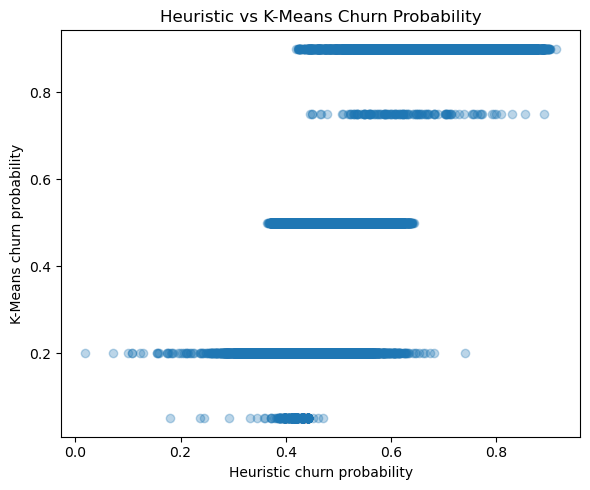

     recency_days  total_purchases  log_total_spend  prob_churn_heuristic  \
775          2005               25        17.260096              0.741393   

     churn_prob_kmeans  
775                0.2  
Empty DataFrame
Columns: [recency_days, total_purchases, log_total_spend, prob_churn_heuristic, churn_prob_kmeans]
Index: []


In [110]:
df_compare = user_features[['churn_prob_kmeans', 'UserId']].copy()
df_compare = df_compare.merge(
    df_h[['UserId', 'prob_churn_heuristic']],
    on='UserId',
    how='left'
)

# Compare basic statistics
print(df_compare[['churn_prob_kmeans', 'prob_churn_heuristic']].describe())

# Correlation between the two probabilities
corr = df_compare['prob_churn_heuristic'].corr(
    df_compare['churn_prob_kmeans'])
print("\n Correlation : ",corr)

# Scatter plot: heuristic vs K-Means
plt.figure(figsize=(6, 5))
plt.scatter(
    df_compare['prob_churn_heuristic'],
    df_compare['churn_prob_kmeans'],
    alpha=0.3
)
plt.xlabel("Heuristic churn probability")
plt.ylabel("K-Means churn probability")
plt.title("Heuristic vs K-Means Churn Probability")
plt.tight_layout()
plt.show()

# Users with high heuristic risk but low K-Means risk
high_heuristic_low_kmeans = user_features[
    (user_features['prob_churn_heuristic'] > 0.7) &
    (user_features['churn_prob_kmeans'] < 0.3)
].head(5)
print(high_heuristic_low_kmeans[['recency_days', 'total_purchases', 'log_total_spend',
     'prob_churn_heuristic', 'churn_prob_kmeans']])


# Users with low heuristic risk but high K-Means risk
low_heuristic_high_kmeans = user_features[
    (user_features['prob_churn_heuristic'] < 0.3) &
    (user_features['churn_prob_kmeans'] > 0.7)
].head(5)

print(low_heuristic_high_kmeans[['recency_days', 'total_purchases', 'log_total_spend',
     'prob_churn_heuristic', 'churn_prob_kmeans']])

<hr style="border:4px solid #999">

# **7. Build final churn probabilities**
In the absence of labeled churn: \
combined heuristic churn risk (40%) with K-Means–based behavioral risk (60%) to balance interpretability and data-driven segmentation.

In [120]:
# combined probability 
user_features['prob_churn_combined'] = (
    0.4 * df_compare['prob_churn_heuristic'] +
    0.6 * df_compare['churn_prob_kmeans']
)

(user_features[['UserId','cluster', 'prob_churn_combined','prob_churn_heuristic','churn_prob_kmeans']]).to_csv("artifacts/churn_scores_combined.csv", index=False)